In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')
pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


No projector specified for this dataset. Please consider the method self.add_proj.


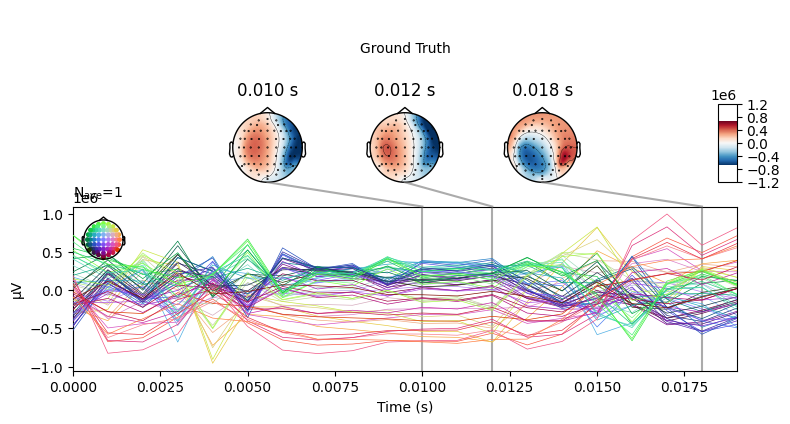

In [9]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1000,
    n_sources=10,
    n_orders=2,
    snr_range=(1e99, 2e99),
    n_timecourses=2000,
    n_timepoints=20,
    scale_data=True)

gen = generator(fwd, **sim_params)

x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)
                        
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# Algo

In [5]:
import torch
from torch import nn

class TransformerModel(torch.nn.Module):

    def __init__(self):
        super(TransformerModel, self).__init__()

        self.transformer = nn.Transformer(nhead=4, num_encoder_layers=4)
        self.softmax = nn.Softmax()

    def forward(self, x, tgt):
        x = self.transformer(x, tgt)
        # x = self.linear1(x)
        x = self.softmax(x)
        return x


In [23]:
import sys; sys.path.insert(0,"../../transformer/")
from tst import Transformer
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

d_input = n_chans
d_output = n_dipoles
d_model = 20
q = 10
v = 10
h = 8
N = 10
attention_size = 10 # Attention window size
dropout = 0. # Dropout rate
pe = None # Positional encoding
chunk_mode = None

net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

# Train

In [24]:
from tqdm.notebook import tqdm
import numpy as np
EPOCHS = 1000
interval = 10
# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    if idx_epoch % interval == 0:
        x, y = gen.__next__()

    x_np = torch.from_numpy(x.astype(np.float32)).to(device)
    y_np = torch.from_numpy(y.astype(np.float32)).to(device)

    running_loss = 0
    print(idx_epoch)
    optimizer.zero_grad()

    # Propagate input
    netout = net(x_np)

    # Comupte loss
    loss = loss_function(y_np, netout)

    # Backpropage loss
    loss.backward()

    # Update weights
    optimizer.step()

    running_loss += loss.item()
    
    train_loss = running_loss
    
    hist_loss[idx_epoch] = train_loss
    print(train_loss)
    # hist_loss_val[idx_epoch] = val_loss

    # if val_loss < val_loss_best:
    #     val_loss_best = val_loss
    #     torch.save(net.state_dict(), model_save_path)

0
0.26914986968040466
1
0.2588677704334259
2
0.25355565547943115
3
0.24994030594825745
4
0.24648630619049072
5
0.24304518103599548
6
0.2394963502883911
7
0.2358105182647705
8
0.23204217851161957
9
0.2282509058713913
10
0.22443711757659912
11
0.22066336870193481
12
0.21689631044864655
13
0.21313083171844482
14
0.20936168730258942
15
0.20558509230613708
16
0.20180076360702515
17
0.19801542162895203
18
0.19424152374267578
19
0.19049112498760223
20


KeyboardInterrupt: 

In [19]:
x_test, y_test = gen.__next__()
x_np_test = torch.from_numpy(x_test.astype(np.float32)).to(device)
y_np_test = torch.from_numpy(y_test.astype(np.float32)).to(device)

y_out = net(x_np_test)
y_out = y_out.cpu().detach().numpy()

In [22]:
idx = 1

stc_ = stc.copy()
stc_.data = y_test[idx].T
stc_.plot(**pp)

stc_ = stc.copy()
stc_.data = y_out[idx].T
stc_.plot(**pp)

Using control points [0.01565026 0.01617742 0.02046   ]
Using control points [0.01565245 0.01618294 0.02045514]
